# DSFB Assignment 1 - Credit Default (Advanced Models)

By [Omid Shahmirzadi](https://ch.linkedin.com/in/omidshahmirzadi) - Email  [omid.shahmirzadi@epfl.ch](mailto:omid.shahmirzadi@epfl.ch)

In this assignment, we try to predict the probability of default on a credit card account based on the dataset of customer default payments that you already used and are familiar with from Demo 0. From a risk management perspective, the accuracy of the predicted probability of default is more valuable than just a binary prediction (classification) of default itself. 

![](https://greendayonline.com/wp-content/uploads/2017/03/Recovering-From-Student-Loan-Default.jpg)

Image source: https://greendayonline.com/wp-content/uploads/2017/03/Recovering-From-Student-Loan-Default.jpg

Dataset source: *Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.*

The dataset consists of information of 30,000 clients with the following 23 features:

  * LIMIT_BAL: Amount of the given credit (Taiwanese Dollar) which includes both the individual consumer credit and his/her family (supplementary) credit.  

  * SEX: Gender (1 = male; 2 = female).   

  * EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).   

  * MARRIAGE: Marital status (0 = unknown; 1 = married; 2 = single; 3 = others).   

  * AGE: Age (year).   

  * PAY1 - PAY6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: PAY1 = the repayment status in September, 2005; PAY2 = the repayment status in August, 2005; . . .;PAY6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -2 = payment two months in advance; -1 = payment one month in advance; 0 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.  
  
  * BILL_AMT1-BILL_AMT6: Amount of bill statement (Taiwanese Dollar). BILL_AMT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; . . .; BILL_AMT6 = amount of bill statement in April, 2005.   

  * PAY_AMT1-PAY_AMT6: Amount of previous payment (Taiwanese Dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; . . .; PAY_AMT6 = amount paid in April, 2005. 

The target variable is given in a separate field called 'default_payment_next_month', where 1 denotes default in the following month and 0 denotes otherwise.

As you might remember, we tried to predict customer defaults using logistic regression. The validation of our results was based on a simple cross validation by splitting data into a training set and a test set. We also used class labels instead of class probabilities. Here we try to elaborate more on this problem, using different models and more statistically sound cross validation schemas and performance metrics.

In [71]:
# Cell to import all the data needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Data Preprocessing and EDA

**Q 1:** Which features need to be one-hot encoded and why? Shall you do that for all categorical features ? Perform the required one-hot encoding and save your pre-processed data into a new data frame.

Hint: Use the *get_dummies()* function of Pandas.

##### Solution :
The features that are categorical must be one-hot encoded. Moreovere one set of this features must not be a subset of the same feature. For exemple the feature education is a categorical feature but the set University  is a subset of the set HighSchool since every person at the university graduated from highschool. Therefore in our case the features SEX and MARRIAGE must be one-hot encoded. The others features are either numerical or ordinal with acceptable labeling.

In [93]:
# Load data into a dataframe

data = pd.read_csv('credit_data.csv')
#check if there are some NaN values in the Dataframe
print(data.isnull().values.any())

# One hot encoding of sex and marital status
# Applying one-hot encoding for other field doesn't make sense since they are either numeric or ordinal

cols_to_transform = ['SEX', 'MARRIAGE']
data_with_dummies = pd.get_dummies( data=data, columns = cols_to_transform )

print(data_with_dummies.columns)

False
Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month', 'SEX_1', 'SEX_2', 'MARRIAGE_0',
       'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')


In [94]:
print(data_with_dummies.head())

   ID  LIMIT_BAL  EDUCATION  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
0   1      20000          2   24      2      2     -1     -1     -2     -2   
1   2     120000          2   26     -1      2      0      0      0      2   
2   3      90000          2   34      0      0      0      0      0      0   
3   4      50000          2   37      0      0      0      0      0      0   
4   5      50000          2   57     -1      0     -1      0      0      0   

      ...      PAY_AMT4  PAY_AMT5  PAY_AMT6  default_payment_next_month  \
0     ...             0         0         0                           1   
1     ...          1000         0      2000                           1   
2     ...          1000      1000      5000                           0   
3     ...          1100      1069      1000                           0   
4     ...          9000       689       679                           0   

   SEX_1  SEX_2  MARRIAGE_0  MARRIAGE_1  MARRIAGE_2  MARRIAGE_3  
0      0      

**Q 2:** Obtain correlation of different features compare to the target using Pearson correlation. What are the most correlated ones? Why not only consider them to do the prediction task?  

Hint: To compute Pearson correlation of two dataframe columns A and B, do the following:

*df['A'].corr(df['B'])*

In [95]:
# Compute the correlation matrix
corr = data_with_dummies.corr()
corr_results = corr['default_payment_next_month']
print(corr_results)
print(corr_results.min())

ID                           -0.013952
LIMIT_BAL                    -0.153520
EDUCATION                     0.028006
AGE                           0.013890
PAY_1                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BILL_AMT1                    -0.019644
BILL_AMT2                    -0.014193
BILL_AMT3                    -0.014076
BILL_AMT4                    -0.010156
BILL_AMT5                    -0.006760
BILL_AMT6                    -0.005372
PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default_payment_next_month    1.000000
SEX_1                         0.039961
SEX_2                        -0.039961
MARRIAGE_0               

#### Solution :
The most correlated features are the ones with the biggest and smallest correlation. All the ones with a correlation close to 0 are uncorrelated.

The most correlated ones are therefore PAY_1 to 6

We consider also the ones with less correlation to get a more precise predictions.

## Part 2: Choosing Performance Metric and Baseline

**Q 1:** What could be a fair metric for this problem? discuss different options starting from the plain accuracy.

Hint: Consider the case where distribution of different classes are not uniform. Also consider the cut-off threshold to separate positive and negative classes. Find a popular metric which is not sensitive to class distributions as well as cut-off threshold and use it for the rest of your analysis.

##### Solution :
The accuracy is a very useful metric to measure the results of a model. After training on the Train set (for exemple 80% of the dataset) We would compare the classification predicted by the model on the Testing set(the rest of the dataset) with the true result of the testing set. We compute a Pourcentage of matching prediction. The higher the accuracy is, the better our model performs. 
To Resume it is a good way to measure the results of a model. The only problem is that it is misleading when the distribution between classes is skewed.
 
We also know that : Sampling differences can affect the final performance of the model, especially when tested against a small holdout set of testing data. Therefore, the models might perform very differently on a different population.

Therefore in our case accuracy might not be the best way to evaluate our model. 

We have a few technics to improve our evaluation step. 

We can use the K-flod cross validation. It will evaluate our model with different training and testing set. We then can at the end perform the average of our result to get a proper evaluation step. It will avoid problem raising from cut-off threshold for testing/training data. 

We could also verify to have the same proportion of positive and negative data in the spliting dataset than in the Whole dataset

Another good way to compare models even with different class distributions is computing the expected value as follow using the confusion metrix and the benefits metrix.
Expected Value =
    p(pos) * [ p(Y|pos)*b(Y,pos) + p(N|pos)*b(N,pos) ] +
    p(neg) * [ p(N|neg)*b(N,neg) + p(Y|neg)*b(Y,neg) ]

But for now we cannot compute the benefits metrix.

Finally we can use The True Positive True Negative False Positive and False Negative  by computing the confusion metric to evaluate our results.
From those 4 measures we can derive the F Score, F1 score, the recall and Precision of our model.

#### With our Problem we are more interested by the Precision score of the positive class which means the precision of the prediction of the default of payment. Better ou model is Higher will this score be

In [96]:
### CHECK CONFUSION MATRIX CODE CHANGE THE TEXT ABOVE
from sklearn.metrics import confusion_matrix

def get_results(y_test,y_pred):
    print ('confusion matrix: \n', confusion_matrix(y_test, y_pred))

    # calculate precision, recall and F score based on confusion metrics
    # note for each class, metrics are calculated separately since average option is set to None 
    precision = precision_score(y_test, y_pred, average=None)
    print ('precision: ', precision)
    recall = recall_score(y_test, y_pred, average=None)
    print ('recall: ', recall)
    f1 = f1_score(y_test, y_pred, average=None)
    print ('F score: ', f1)
    print('The precision score of class 1(default next month) is :'+str(precision[1]))
    return

**Q 2:** Come up with a sensible baseline to compare with your more complex models based on your selected metric. Print the baseline performance.

Hint: Divide data into training and test sets using *train_test_split()* function in *sklearn.model_selection* package. Then fit an object from *DummyClassifier* class in *sklearn.dummy* package to training set and evaluate the performance on the test set. Keep the strategy of *DummyClassifier* object as default (stratified).

In [97]:
# SPLIT data into training and testing sets
from sklearn.model_selection import train_test_split

X = data_with_dummies.loc[:, ['LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'SEX_2', 'MARRIAGE_0',
       'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']]

y = data_with_dummies['default_payment_next_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [27]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train,y_train)
y_pred = dummy_clf.predict(X_test)
baseline_score = dummy_clf.score(X_test,y_test)
print ("Mean accuracy : "+str(baseline_score))

get_results(y_test,y_pred)

Mean accuracy : 0.6523333333333333
confusion matrix: 
 [[3628 1045]
 [1034  293]]
precision:  [0.77820678 0.21898356]
recall:  [0.77637492 0.22079879]
F score:  [0.77728977 0.21988743]
The precision score of class 1(default next month) is :0.21898355754857998


## Part 3: Prediction using Logistic Regression

**Q 1:** Predict probability of default using logistic regression. Is normalization of data needed? What is the performance of your model ?

Hint: Use *LogisticRegression* class from *sklearn.linear_model* package.

##### Solution

It is always better to normalize the features before training a model. It allows the model to get better predictions

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

X_train_normalized = preprocessing.normalize(X_train,norm='max')
X_test_normalized = preprocessing.normalize(X_test,norm='max')
#print(X_train.head())
lr_clf = LogisticRegression()
%time lr_clf.fit(X_train_normalized,y_train)
y_pred = lr_clf.predict(X_test)
lr_score = lr_clf.score(X_test_normalized,y_test)

print ("Mean accuracy : "+str(lr_score))
get_results(y_test,y_pred)

CPU times: user 137 ms, sys: 70 µs, total: 137 ms
Wall time: 137 ms
Mean accuracy : 0.7788333333333334
confusion matrix: 
 [[4641   32]
 [1294   33]]
precision:  [0.78197136 0.50769231]
recall:  [0.99315215 0.02486812]
F score:  [0.875      0.04741379]
The precision score of class 1(default next month) is :0.5076923076923077


**Q 2:** Try to think conceptually what is the correct way to estimate performance of a classifier if we need to tune hyper-parameters. Implement your solution.

Hint: Think about the problem that might arise if we tune hyper-parameters using the training set and the test set.

K-Fold crossvalidation is a very good way to estimate the performance of a classifier if we need to tune hyper-parameters. StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
We can do is as follows.

In [20]:
# K-Fold crossvalidation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
i = 1
for train, test in skf.split(X,y):
    print("-------------------FOLD"+ str(i)+" ----------------------------")
    print("fold %i: train set shape: %s test set shape: %s" % (i, train.shape, test.shape))
    print("fold %i: train set: %s test set: %s" % (i, train, test))
    #Select the appropriate part of the dataframe based on the array of index train and test
    X_train_normalized = preprocessing.normalize(X.iloc[train,:],norm="max")
    y_train = y.iloc[train]
    X_test_normalized = preprocessing.normalize(X.iloc[test,:],norm="max")
    y_test = y.iloc[test]
    #print(y_train)
    # Train our Model
    %time lr_clf.fit(X_train_normalized,y_train)
    # Predict our Results
    y_pred = lr_clf.predict(X_test_normalized)
    lr_score = lr_clf.score(X_test_normalized,y_test)
    #Print our Results
    print ("Mean accuracy : "+str(lr_score))
    get_results(y_test,y_pred)
    i+=1

lr_clf

-------------------FOLD1 ----------------------------
fold 1: train set shape: (23999,) test set shape: (6001,)
fold 1: train set: [ 5984  5985  5988 ... 29997 29998 29999] test set: [   0    1    2 ... 6044 6045 6047]
CPU times: user 138 ms, sys: 442 µs, total: 138 ms
Wall time: 138 ms
Mean accuracy : 0.7788701883019497
confusion matrix: 
 [[4673    0]
 [1327    1]]
precision:  [0.77883333 1.        ]
recall:  [1.00000000e+00 7.53012048e-04]
F score:  [0.87566757 0.00150489]
The precision score of class 1(default next month) is :1.0
-------------------FOLD2 ----------------------------
fold 2: train set shape: (24000,) test set shape: (6000,)
fold 2: train set: [    0     1     2 ... 29997 29998 29999] test set: [ 5984  5985  5988 ... 12049 12050 12051]
CPU times: user 190 ms, sys: 159 ms, total: 350 ms
Wall time: 161 ms
Mean accuracy : 0.7788333333333334
confusion matrix: 
 [[4673    0]
 [1327    0]]
precision:  [0.77883333 0.        ]
recall:  [1. 0.]
F score:  [0.87566757 0.       

/home/julien/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/julien/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 201 ms, sys: 117 ms, total: 318 ms
Wall time: 198 ms
Mean accuracy : 0.7788333333333334
confusion matrix: 
 [[4673    0]
 [1327    0]]
precision:  [0.77883333 0.        ]
recall:  [1. 0.]
F score:  [0.87566757 0.        ]
The precision score of class 1(default next month) is :0.0
-------------------FOLD5 ----------------------------
fold 5: train set shape: (24001,) test set shape: (5999,)
fold 5: train set: [    0     1     2 ... 24073 24074 24075] test set: [23688 23691 23696 ... 29997 29998 29999]


/home/julien/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/julien/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 254 ms, sys: 78.6 ms, total: 332 ms
Wall time: 255 ms
Mean accuracy : 0.7787964660776796
confusion matrix: 
 [[4672    0]
 [1327    0]]
precision:  [0.77879647 0.        ]
recall:  [1. 0.]
F score:  [0.87564427 0.        ]
The precision score of class 1(default next month) is :0.0


/home/julien/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/julien/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Second Version: print only the accuracy scores

In [26]:
from sklearn.cross_validation import cross_val_score

cross_val = cross_val_score(LogisticRegression(), preprocessing.normalize(X,norm='max'), y, scoring='accuracy', cv=10)

print("Accuracy for each fold")
print(cross_val)
print("Mean Accuracy")
print(cross_val.mean())

Accuracy for each fold
[0.77874042 0.77874042 0.77874042 0.77874042 0.77866667 0.77833333
 0.77892631 0.77892631 0.77925975 0.77892631]
Mean Accuracy
0.778800035900004


**Q 3:** Tune the parameter *C* using *l1* penalty. Note that data normalization is required for regularized linear models. What is the correct method to implement the normalization ? Obtain the performance of the model using best value of *C*.

Hint: Think about the possible problem that might arise if we standardize all data (training and test) and then fit a classifier to it. Read about *Pipeline* class from *sklearn.pipeline* package and see how taking advantage of *Pipeline* can avoid the mentioned problem.

##### Solution :
The sklearn.pipeline module implements utilities to build a composite estimator, as a chain of transforms and estimators.
It gives us the opportunity to apply the same transformation in the same order on our data each time.

We will use standard scaler to normalize our data for regularized liner models

In [75]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#As for the regularization factor, we consider an exponential range of values
alpha_to_test = 2.0**np.arange(-10, +6)

pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LogisticRegression(penalty='l1'))
            ])

params = {'regressor__C': alpha_to_test}

gridsearch = GridSearchCV(pipe, params, verbose=1).fit(X_train, y_train)
print('Final score is: ', gridsearch.score(X_test, y_test))

#pipe = pipe.fit(X_train, y_train)
gridsearch.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   19.3s finished


Final score is:  0.8113333333333334


{'regressor__C': 0.25}

The best value of C is 0.25

In [76]:
lr_clf = LogisticRegression(penalty='l1',C=gridsearch.best_params_['regressor__C'])
lr_clf.fit(X_train,y_train)
y_test = lr_clf.predict(X_test)
#print results
get_results(y_test,y_pred)

confusion matrix: 
 [[3773 1792]
 [ 165  270]]
precision:  [0.95810056 0.13094083]
recall:  [0.67798742 0.62068966]
F score:  [0.79406503 0.21625951]
The precision score of class 1(default next month) is :0.1309408341416101


**Q 4:** Check the coefficients and intercept of your tuned model under *l1* regularization.

Hint: Extract the logistic regression from your pipeline and use its methods directly.

In [74]:
clf=gridsearch.best_estimator_.named_steps['regressor']
print(clf)
print("Coefficient : "+str(clf.coef_))
print("Intercept : "+str(clf.intercept_))

LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Coefficient : [[-0.10992314 -0.07768952  0.05230196  0.6516184   0.09809659  0.07943354
   0.03713665  0.03573404  0.         -0.3295948   0.12258446  0.0804357
   0.00253957  0.02317748  0.         -0.20866417 -0.24788842 -0.02932627
  -0.04100516 -0.04659603 -0.02377498  0.00992231 -0.04738577 -0.05285821
   0.02795191 -0.06923467  0.        ]]
Intercept : [-1.46265186]


**Q 5:** Draw the ROC curve of your tuned model under *l1* regularization.

Hint: Use *roc_curve* function from *sklearn.metrics* package.

(6000,)
(6000,)
false positive rates:  [0.         0.02567944 1.        ] 
 true positive rates:  [0.         0.23737754 1.        ] 
 thresholds:  [2 1 0]
area under roc curve:  0.6058490541391962


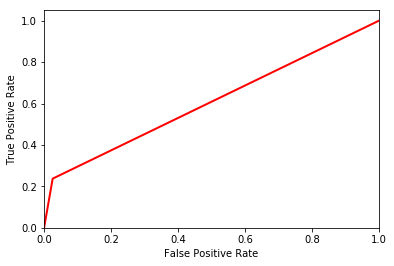

In [80]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred = gridsearch.predict(X_test)
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print ('false positive rates: ',fpr,'\n','true positive rates: ',
       tpr,'\n','thresholds: ',thresholds)
roc_auc = auc(fpr, tpr)
print ('area under roc curve: ', roc_auc)

# plot roc curve
plt.plot(fpr, tpr, color='red',lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Part 4: Prediction using KNN Classifier

**Q 1:** What could be the advantage of knn over logistic regression? Shall the data be normalized ?

##### Solution :

- Training: k-nearest neighbors requires no training. Logistic regression requires some training.
- Decision boundary: Logistic regression learns a linear classifier, while k-nearest neighbors can learn non-linear boundaries as well.



Normalization : THe disctance is important to classify my featurs thus there is no need to normalize

**Q 2:** Try to fit a knn classifier with 5 nearest nieghbors using training and test sets. Is normalization necessary ?

Hint: Use the *KNeighborsClassifier* class from *sklearn.neighbors* package.

##### Solution :

Normalization : THe disctance is important to classify my featurs thus there is no need to normalize

In [99]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

n_neighbors = 5 
clf_knn = KNeighborsClassifier(n_neighbors)
#train
clf_knn.fit(X_train, y_train)
#predict
y_pred = clf_knn.predict(X_test)
lr_score = clf_knn.score(X_test,y_test)

#print results
print ("Mean accuracy : "+str(lr_score))
get_results(y_test,y_pred)

Mean accuracy : 0.7533333333333333
confusion matrix: 
 [[4272  401]
 [1079  248]]
precision:  [0.79835545 0.38212635]
recall:  [0.91418789 0.18688772]
F score:  [0.85235435 0.25101215]
The precision score of class 1(default next month) is :0.38212634822804314


**Q 3:** Tune the parameter *n_neighbors* and report the perfromance of your tuned model.

In [105]:
#k to tetst
k_to_test = np.arange(1, 40)

pipe = Pipeline([
            ('regressor', KNeighborsClassifier())
            ])

params = {'regressor__n_neighbors': k_to_test}

gridsearch = GridSearchCV(pipe,params,n_jobs=4, verbose=1).fit(X_train, y_train)
print('Final score is: ', gridsearch.score(X_test, y_test))

#pipe = pipe.fit(X_train, y_train)
gridsearch.best_params_

Fitting 3 folds for each of 39 candidates, totalling 117 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:  4.2min finished


Final score is:  0.7801666666666667


{'regressor__n_neighbors': 36}

In [106]:
clf_knn2=KNeighborsClassifier(weights='uniform',n_neighbors=gridsearch.best_params_['regressor__n_neighbors'])
clf_knn2.fit(X_train,y_train)
y_pred=clf_knn2.predict(X_test)

#print results
get_results(y_test,y_pred)

confusion matrix: 
 [[4574   99]
 [1220  107]]
precision:  [0.78943735 0.51941748]
recall:  [0.97881447 0.08063301]
F score:  [0.8739849  0.13959556]
The precision score of class 1(default next month) is :0.5194174757281553


**Q 4:** Apply knn classifier using *'weighted'* strategy which gives different weights to different neighbors based on their distance from the focal data point. 

Hint: Modify the *weights* parameter of your knn classifier object, instantiated in the previous question.

In [107]:
#k to tetst
k_to_test = np.arange(1, 40)

pipe = Pipeline([
            ('regressor', KNeighborsClassifier(weights='distance'))
            ])

params = {'regressor__n_neighbors': k_to_test}

gridsearch = GridSearchCV(pipe,params,n_jobs=4, verbose=1).fit(X_train, y_train)
print('Final score is: ', gridsearch.score(X_test, y_test))

#pipe = pipe.fit(X_train, y_train)
gridsearch.best_params_

Fitting 3 folds for each of 39 candidates, totalling 117 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:  4.2min finished


Final score is:  0.779


{'regressor__n_neighbors': 38}

In [108]:
clf_knn2=KNeighborsClassifier(weights='distance',n_neighbors=gridsearch.best_params_['regressor__n_neighbors'])
clf_knn2.fit(X_train,y_train)
y_pred=clf_knn2.predict(X_test)
#print results
get_results(y_test,y_pred)

confusion matrix: 
 [[4534  139]
 [1187  140]]
precision:  [0.79251879 0.50179211]
recall:  [0.97025465 0.10550113]
F score:  [0.8724264 0.1743462]
The precision score of class 1(default next month) is :0.5017921146953405


## Part 5: Prediction using Classifiers based on Decision Trees

**Q 1:** How do you think about the required preprocessing for decision tree ? In particular discuss the case of one hot encoding and normalization.

##### Solution :
- Preprocessing : ...
    -One Hot Encoded
- Normalization : ...

**Q 2:** Fit a decision tree classifier to your data, with no hyper-parameter tuning, using training and test sets and report the performance of your model. Do the same with a different train and test set. How do the results compare? What are the most important features in either of the cases? Visualize your second tree classifier using *sklearn.tree.export_graphviz* function.

Hint: Use the *DecisionTreeClassifier* class from *sklearn.tree* package. The *feature_importances_* attribute of this classs, reports the importance of different features. 

In [81]:
def importance_features(clf,n_importance):
    print("Importance of features "+str(clf.feature_importances_))
    arr = np.array(clf.feature_importances_)
    idx = (-arr).argsort()[:n_importance]
    print("The "+str(n_importance)+" most important features are ")
    return X.columns[idx]

In [82]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

decTree_clf = DecisionTreeClassifier()
decTree_clf.fit(X=X_train,y=y_train)
y_pred = decTree_clf.predict(X_test)

#print results
score = decTree_clf.score(X_test,y_test)
print ("Mean accuracy : "+str(score))
get_results(y_test,y_pred)

Mean accuracy : 0.731
confusion matrix: 
 [[3853  820]
 [ 794  533]]
precision:  [0.82913708 0.39393939]
recall:  [0.82452386 0.40165787]
F score:  [0.82682403 0.39776119]
The precision score of class 1(default next month) is :0.3939393939393939


In [83]:
importance_features(decTree_clf,5)

Importance of features [0.05600363 0.02274681 0.07497557 0.16151301 0.03444798 0.01148501
 0.01096667 0.01071479 0.01151093 0.06516502 0.04981126 0.04386343
 0.04213452 0.04193262 0.05097436 0.04733499 0.04403153 0.05937182
 0.03327306 0.04560955 0.05207903 0.00682142 0.00780248 0.0007128
 0.00673148 0.00651367 0.00147256]
The 5 most important features are 


Index(['PAY_1', 'AGE', 'BILL_AMT1', 'PAY_AMT3', 'LIMIT_BAL'], dtype='object')

In [84]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

decTree_clf = DecisionTreeClassifier()
decTree_clf.fit(X=X_train,y=y_train)
y_pred = decTree_clf.predict(X_test)

#print results
score = decTree_clf.score(X_test,y_test)
print ("Mean accuracy : "+str(score))
get_results(y_test,y_pred)
print("Importance of features "+str(decTree_clf.feature_importances_))

Mean accuracy : 0.7298333333333333
confusion matrix: 
 [[3803  870]
 [ 751  576]]
precision:  [0.83509003 0.39834025]
recall:  [0.8138241  0.43406179]
F score:  [0.82431993 0.41543455]
The precision score of class 1(default next month) is :0.3983402489626556
Importance of features [0.06847666 0.0192049  0.06703385 0.16157826 0.03301541 0.00693859
 0.00862445 0.00889787 0.01231635 0.06475555 0.05190677 0.04543107
 0.04396475 0.04167039 0.05078537 0.04715333 0.05175381 0.05743657
 0.03718585 0.04145127 0.05109278 0.00681504 0.00581707 0.00092672
 0.00635947 0.00722212 0.00218574]


In [85]:
importance_features(decTree_clf,5)

Importance of features [0.06847666 0.0192049  0.06703385 0.16157826 0.03301541 0.00693859
 0.00862445 0.00889787 0.01231635 0.06475555 0.05190677 0.04543107
 0.04396475 0.04167039 0.05078537 0.04715333 0.05175381 0.05743657
 0.03718585 0.04145127 0.05109278 0.00681504 0.00581707 0.00092672
 0.00635947 0.00722212 0.00218574]
The 5 most important features are 


Index(['PAY_1', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT3'], dtype='object')

Both results are very Similar

In [86]:

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(decTree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ImportError: No module named 'pydotplus'

In [ ]:
from subprocess import check_call
check_call(['dot','-Tpng','tree.dot','-o','OutputFile.png'])

**Q 3:** Fit a random forest classifier to your data by adjusting the total number of trees. How do your results compare to a single decision tree? report importance of different features.

Hint: Use the *RandomForestClassifier* class from *sklearn.ensemble* package.

In [112]:
from sklearn.ensemble import RandomForestClassifier 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

n_to_test = np.arange(1, 200)

pipe = Pipeline([
            ('regressor', RandomForestClassifier())
            ])

params = {'regressor__n_estimators': n_to_test}

gridsearch = GridSearchCV(pipe,params,n_jobs=4, verbose=1).fit(X_train, y_train)
print('Final score is: ', gridsearch.score(X_test, y_test))


Fitting 3 folds for each of 199 candidates, totalling 597 fits


[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 208 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 458 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done 597 out of 597 | elapsed: 27.9min finished


Final score is:  0.8166666666666667


TypeError: __init__() got an unexpected keyword argument 'n_neighbors'

In [113]:

randTree_clf = RandomForestClassifier(n_estimators=gridsearch.best_params_['regressor__n_estimators'])
randTree_clf.fit(X=X_train,y=y_train)
y_pred = randTree_clf.predict(X_test)

#print results
score = randTree_clf.score(X_test,y_test)
print ("Mean accuracy : "+str(score))
get_results(y_test,y_pred)

Mean accuracy : 0.8158333333333333
confusion matrix: 
 [[4392  281]
 [ 824  503]]
precision:  [0.84202454 0.64158163]
recall:  [0.93986732 0.37905049]
F score:  [0.88825968 0.4765514 ]
The precision score of class 1(default next month) is :0.6415816326530612


In [114]:
gridsearch.best_params_['regressor__n_estimators']

131

In [115]:
importance_features(randTree_clf,5)

Importance of features [0.05931126 0.01995874 0.0656581  0.09933462 0.0472319  0.02317351
 0.02455875 0.02198946 0.01768895 0.06037702 0.05268554 0.05079133
 0.04961764 0.04915152 0.04852466 0.05021566 0.04691439 0.04523865
 0.04285169 0.04285532 0.04570146 0.00843819 0.00871725 0.00033025
 0.00856199 0.00843093 0.00169121]
The 5 most important features are 


Index(['PAY_1', 'AGE', 'BILL_AMT1', 'LIMIT_BAL', 'BILL_AMT2'], dtype='object')

**Q 4:** Fit a gradient boosted tree classifier to your data by tunning the total number of trees. How do your results compare to the other models? What are the most important features?

Hint: Use the *GradientBoostingClassifier* class from *sklearn.ensemble* package.

In [89]:
from sklearn.ensemble import GradientBoostingClassifier 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

GradTree_clf = GradientBoostingClassifier()
GradTree_clf.fit(X=X_train,y=y_train)
y_pred = GradTree_clf.predict(X_test)

#print results
score = GradTree_clf.score(X_test,y_test)
print ("Mean accuracy : "+str(score))
get_results(y_test,y_pred)

Mean accuracy : 0.8205
confusion matrix: 
 [[4445  228]
 [ 849  478]]
precision:  [0.83962977 0.67705382]
recall:  [0.95120907 0.360211  ]
F score:  [0.89194341 0.47024102]
The precision score of class 1(default next month) is :0.6770538243626062


In [90]:
importance_features(GradTree_clf,6)

Importance of features [0.06620478 0.02172896 0.04125565 0.15261758 0.02794735 0.02883496
 0.02214051 0.03128873 0.02496172 0.11314753 0.05855562 0.04166046
 0.03623507 0.03687666 0.03771943 0.05383595 0.0403825  0.03197003
 0.02026025 0.05029455 0.02428331 0.0104192  0.00210666 0.00777023
 0.0093936  0.0081087  0.        ]
The 6 most important features are 


Index(['PAY_1', 'BILL_AMT1', 'LIMIT_BAL', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT5'], dtype='object')

##### This is the best classifier we have so far !

## Part 6: Feature Selection / Projection

**Q 1:** Fit a logistic regression (with no l1 and l2 regularization) to the top 6 important features obtained from Q 4 of part 5. How do you compare the performance of this model to the logistic regression model trained on all features ?

In [50]:
X_6 = X.loc[:,['PAY_1', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_AMT1', 'BILL_AMT2', 'PAY_AMT5']]

print(X_6.head())

X_train, X_test, y_train, y_test = train_test_split(X_6, y, test_size=0.2, random_state=1, stratify=y)


X_train_normalized = preprocessing.normalize(X_train,norm='max')
X_test_normalized = preprocessing.normalize(X_test,norm='max')

lr_clf = LogisticRegression()
lr_clf.fit(X_train_normalized,y_train)
y_pred = lr_clf.predict(X_test)
lr_score = lr_clf.score(X_test_normalized,y_test)

print ("Mean accuracy : "+str(lr_score))
get_results(y_test,y_pred)

   PAY_1  BILL_AMT1  LIMIT_BAL  PAY_AMT1  BILL_AMT2  PAY_AMT5
0      2       3913      20000         0       3102         0
1     -1       2682     120000         0       1725         0
2      0      29239      90000      1518      14027      1000
3      0      46990      50000      2000      48233      1069
4     -1       8617      50000      2000       5670       689
Mean accuracy : 0.7788333333333334
confusion matrix: 
 [[3203 1470]
 [ 735  592]]
precision:  [0.81335703 0.2870999 ]
recall:  [0.68542692 0.44611907]
F score:  [0.74393218 0.34936559]
The precision score of class 1(default next month) is :0.2870999030067895


The results are slightly differente. The overral accuracy is the same but the precision of the class 1 is way better when training on all the features.

**Q 2:** Apply PCA to project your data into 6 dimensions and fit a logistic regression as Q 1. How you compare the performance of your model?

Hint: Use the *PCA* class from *sklearn.decomposition* package. Create a pipeline consists of *StandardScaler*, *PCA* and *LogisticRegression* classes.

In [59]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#As for the regularization factor, we consider an exponential range of values
#alpha_to_test = 2.0**np.arange(-10, +6)

pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('reduce_dim',PCA(n_components=6)),
            ('regressor', LogisticRegression())
            ])
params = {'reduce_dim': [PCA()]}

gridsearch = GridSearchCV(pipe, params, verbose=1).fit(X_train, y_train)
print('Final score is: ', gridsearch.score(X_test, y_test))

#pipe = pipe.fit(X_train, y_train)
gridsearch.best_params_


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


Final score is:  0.8116666666666666


{'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)}

In [60]:
y_test = gridsearch.predict(X_test)
get_results(y_test,y_pred)

confusion matrix: 
 [[3772 1789]
 [ 166  273]]
precision:  [0.95784662 0.13239573]
recall:  [0.67829527 0.62186788]
F score:  [0.79418886 0.21831267]
The precision score of class 1(default next month) is :0.13239573229873908


**Q 3:** Visualize your data in 2 dimensions using PCA. What is the disadvantage of PCA when used for visualizing high-dimensional data? What could be a better solution?

Hint: Don't forget to normalize your data before applying PCA. Use *matplotlib.pyplot.scatter* function to plot your data in two dimensions.

##### Solution : 
The disadvantage of PCA when using visualization is that the axis don't not represent any comprehensible measure.
We could instead use different plot with only 2 or 3 features each time

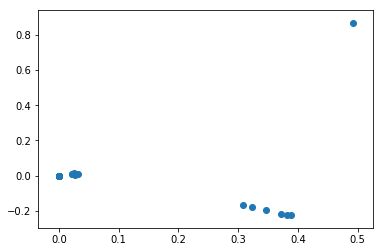

In [73]:
# We assume that we have to vizualize our features in 2 dimensions

# normalize
X_norm = preprocessing.normalize(X,norm='max')
#pca
pca = PCA(n_components=2)
data = pca.fit(X)
#plot
plt.scatter(data.components_[0],data.components_[1])
plt.show()

## Part 7: Prediction Improvement: Better Model

**Q 1:** If model A performas better than all other models for our problem, does it mean that it is in general a better model? Why?

Hint: Google *no-free-lunch* theorem.

##### Solution :
What the NFLT is trying to tell us is, we are generally not going to find off the shelf algorithms that fit perfectly to our data. We are going to have to architect the algorithm to better fit the data — for example, make a Neural Network recurrent to better fit a time series, or make an Multi Layer Perceptron into a Convolutional Neural Network to better understand the spacial information in the input data. 
Thus a composition of different model might be a better solution than individual model

**Q 2:** Create a simple ensmble classifier using average predicted probabilities of  logistic regression (with l1 penalty), knn classifier, random forest classifier and gradient boosted classifier. Compare its performance with each of the 4 individual models.

In [108]:
#lr
lr_clf = LogisticRegression(penalty='l1',C=gridsearch.best_params_['regressor__C'])
lr_clf.fit(X_train,y_train)
#knn
clf_knn2=KNeighborsClassifier(weights='uniform',n_neighbors=36)
clf_knn2.fit(X_train,y_train)
#random forest
randTree_clf = RandomForestClassifier()
randTree_clf.fit(X=X_train,y=y_train)
#gradient boosted
GradTree_clf = GradientBoostingClassifier()
GradTree_clf.fit(X=X_train,y=y_train)
y_pred_ensemble = (GradTree_clf.predict_proba(X_test)+randTree_clf.predict_proba(X_test)+lr_clf.predict_proba(X_test)+clf_knn2.predict_proba(X_test))/4
print(y_pred.shape)
print(y_pred)


(6000, 2)
[[0.88151379 0.11848621]
 [0.79969091 0.20030909]
 [0.91492909 0.08507091]
 ...
 [0.86914187 0.13085813]
 [0.8950265  0.1049735 ]
 [0.96135959 0.03864041]]


In [111]:
print(" The accuracy score of the ensemble classifier is ")
print(np.mean([GradTree_clf.score(X_test,y_test),randTree_clf.score(X_test,y_test),lr_clf.score(X_test,y_test),clf_knn2.score(X_test,y_test)]))


 The accuracy score of the ensemble classifier is 
0.8051666666666667


Accuracy is similar to random forest lower than lr with pca(6) and gradientboost and greater than knn

**Q 3:** How can you make your performance results statistically more reliable ?

Hint: Consider selection bias in both tuning and testing steps.

## Bonus: Food for Thought

To read: https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf

To watch: https://www.ted.com/talks/deb_roy_the_birth_of_a_word#t-316846